In [1]:
import pandas as pd
import numpy as np

In [2]:
news = pd.read_csv("./articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
users = pd.read_csv("./users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [4]:
!pip install gensim
!pip install python-Levenshtein
!pip install razdel
!pip install pymorphy2

  Using cached python-Levenshtein-0.12.2.tar.gz (50 kB)
  Running setup.py clean for python-Levenshtein
Failed to build python-Levenshtein
    Running setup.py install for python-Levenshtein: started
    Running setup.py install for python-Levenshtein: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\Anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\akokutenko\\AppData\\Local\\Temp\\pip-install-ike8jr32\\python-levenshtein_dc3a4c3095114eccbd62094f46251899\\setup.py'"'"'; __file__='"'"'C:\\Users\\akokutenko\\AppData\\Local\\Temp\\pip-install-ike8jr32\\python-levenshtein_dc3a4c3095114eccbd62094f46251899\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\akokutenko\AppData\Local\Temp\pip-wheel-ik54uljt'
       cwd: C:\Users\akokutenko\AppData\Local\Temp\pip-install-ike8jr32\python-levenshtein_dc3a4c3095114eccbd62094f46251899\
  Complete output (27 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\Levenshtein
  copying L

In [5]:
from gensim.corpora.dictionary import Dictionary
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from razdel import tokenize 
import pymorphy2


In [6]:
nltk.download('stopwords')
stopword_ru = stopwords.words('russian')
len(stopword_ru)
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akokutenko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
with open('./stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-8-2b1de38ed3a9>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 24.3 s


In [10]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 11s


In [12]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [14]:
from gensim.models import LdaModel

In [17]:
%%time
N_topic = 30
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 27.2 s


In [18]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [19]:
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(3, 0.10360715),
 (5, 0.058270536),
 (7, 0.2717091),
 (8, 0.05074679),
 (15, 0.33628592),
 (16, 0.1055374),
 (23, 0.058051404)]

In [20]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: женщина тело мужчина обнаружить результат произойти который
topic_1: год это который россия страна также новый
topic_2: северный снижение южный корея американский сша лодка
topic_3: перевод диск азербайджан армения столетие точнее шкала
topic_4: ребёнок население общество сообщество проверка студент девочка
topic_5: место год млн рейтинг составить высота ожидаться
topic_6: медик индия концерн ирак делегация встречный добыть
topic_7: это журнал мочь который весь статья большой
topic_8: научный nn москва открытие район памятник городской
topic_9: космос писать граница объект норма американский знаменитый
topic_10: тур таиланд золото золотой куба мексика дания
topic_11: офицер иран израиль кремль израильский зампред заведение
topic_12: пенсия год превысить прогноз годовой собственность устойчивый
topic_13: население парламент спасти бомба брюссель грузия вдвое
topic_14: банк источник погибнуть человек сотрудник эксперимент который
topic_15: статья иск ст бензин кость температура 

In [21]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [22]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.180707,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.180001,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.139889,0.000000,0.480264
1,4896,0.336684,0.000000,0.0,0.200780,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.440525,0.000000,0.000000,0.000000
2,4897,0.000000,0.000000,0.0,0.103607,0.0,0.058275,0.0,0.271714,0.050746,...,0.336353,0.105728,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.057785,0.000000
3,4898,0.000000,0.045018,0.0,0.028728,0.0,0.000000,0.0,0.643296,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.112781,0.000000
4,4899,0.000000,0.106487,0.0,0.052967,0.0,0.000000,0.0,0.000000,0.000000,...,0.089742,0.000000,0.239212,0.0,0.0,0.0,0.000000,0.115683,0.000000,0.374152


In [23]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [24]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector
get_user_embedding(user_articles_list)

array([0.04872665, 0.19505944, 0.        , 0.00339975, 0.01168071,
       0.00758864, 0.        , 0.02209016, 0.        , 0.0361097 ,
       0.00891656, 0.01266039, 0.        , 0.01296018, 0.03954194,
       0.        , 0.0896359 , 0.17046377, 0.00953097, 0.        ,
       0.02753638, 0.00298838, 0.20174467, 0.08331481, 0.00557822])

In [25]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.061821,0.147959,0.0,0.000000,0.036324,0.009627,0.000000,0.010531,0.089347,...,0.003502,0.053966,0.061467,0.043099,0.000000,0.080133,0.019721,0.089146,0.179463,0.044092
1,u108690,0.033169,0.194430,0.0,0.001727,0.026455,0.004561,0.004129,0.031948,0.002070,...,0.008611,0.123165,0.078562,0.019266,0.002953,0.000000,0.015420,0.177038,0.202891,0.013068
2,u108339,0.091038,0.298388,0.0,0.000000,0.007356,0.006826,0.000000,0.019224,0.031793,...,0.004066,0.024572,0.076621,0.035130,0.008493,0.012148,0.026233,0.132227,0.097586,0.024903


In [26]:
target = pd.read_csv("./users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [27]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.061821,0.147959,0.0,0.000000,0.036324,0.009627,0.000000,0.010531,0.089347,...,0.053966,0.061467,0.043099,0.000000,0.080133,0.019721,0.089146,0.179463,0.044092,0
1,u108690,0.033169,0.194430,0.0,0.001727,0.026455,0.004561,0.004129,0.031948,0.002070,...,0.123165,0.078562,0.019266,0.002953,0.000000,0.015420,0.177038,0.202891,0.013068,1
2,u108339,0.091038,0.298388,0.0,0.000000,0.007356,0.006826,0.000000,0.019224,0.031793,...,0.024572,0.076621,0.035130,0.008493,0.012148,0.026233,0.132227,0.097586,0.024903,1


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [30]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [31]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.10136455, 0.10364832, 0.24734449, 0.19109366, 0.05118298,
       0.07424887, 0.31975314, 0.05234184, 0.09881955, 0.11785071])

In [32]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.255059, F-Score=0.644, Precision=0.595, Recall=0.702


In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1638  117]
 [  74  171]]


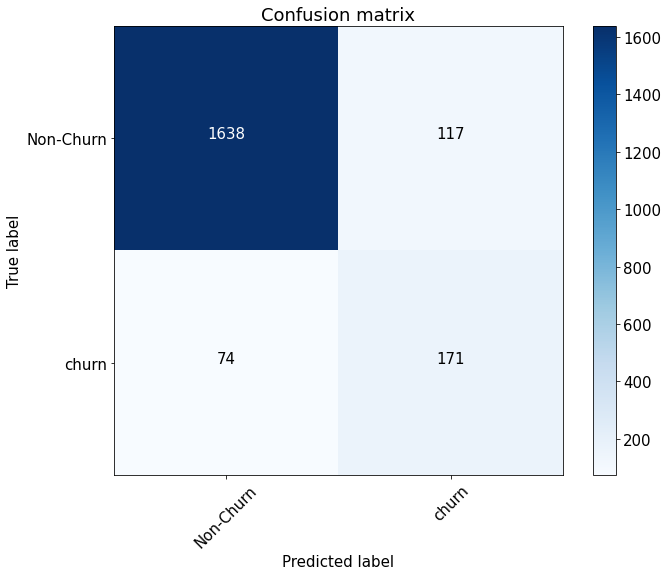

In [35]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [36]:
roc_auc_score(y_test, preds)

0.9315913715913716

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)

In [37]:
def get_user_embedding_M(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [38]:
get_user_embedding_M(user_articles_list)

array([0.        , 0.19977373, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00526796,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.10907241, 0.        , 0.        ,
       0.        , 0.        , 0.14823294, 0.0815061 , 0.        ])

In [39]:
user_embeddings1 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_M(x), 1)])
user_embeddings1.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings1['uid'] = users['uid'].values
user_embeddings1 = user_embeddings1[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.059501,0.128800,0.0,0.0,0.005758,0.0,0.0,0.000000,0.057816,...,0.000000,0.010227,0.000000,0.000000,0.0,0.0,0.000000,0.061316,0.038984,0.021289
1,u108690,0.000000,0.175763,0.0,0.0,0.008816,0.0,0.0,0.014527,0.000000,...,0.007339,0.140998,0.074987,0.000000,0.0,0.0,0.000000,0.177603,0.204821,0.000000
2,u108339,0.079291,0.241106,0.0,0.0,0.000000,0.0,0.0,0.006278,0.006996,...,0.000000,0.022567,0.073753,0.012618,0.0,0.0,0.021801,0.131704,0.084984,0.025118


In [40]:
X1 = pd.merge(user_embeddings1, target, 'left')
X1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.059501,0.128800,0.0,0.0,0.005758,0.0,0.0,0.000000,0.057816,...,0.010227,0.000000,0.000000,0.0,0.0,0.000000,0.061316,0.038984,0.021289,0
1,u108690,0.000000,0.175763,0.0,0.0,0.008816,0.0,0.0,0.014527,0.000000,...,0.140998,0.074987,0.000000,0.0,0.0,0.000000,0.177603,0.204821,0.000000,1
2,u108339,0.079291,0.241106,0.0,0.0,0.000000,0.0,0.0,0.006278,0.006996,...,0.022567,0.073753,0.012618,0.0,0.0,0.021801,0.131704,0.084984,0.025118,1


In [41]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1[['topic_{}'.format(i) for i in range(25)]], 
                                                    X1['churn'], random_state=0)

In [42]:
logreg1 = LogisticRegression()
#обучим 
logreg1.fit(X_train1, y_train1)

LogisticRegression()

In [43]:
preds1 = logreg1.predict_proba(X_test1)[:, 1]
preds1[:10]

array([0.10289626, 0.02486194, 0.29265942, 0.23023782, 0.040414  ,
       0.09176841, 0.19661712, 0.04791899, 0.03387747, 0.18542493])

In [44]:
metric_list=[[i] for i in [thresholds[ix], fscore[ix], precision[ix], recall[ix]]]
metric_list

[[0.2550587871228532],
 [0.6441947565543071],
 [0.5951557093425606],
 [0.7020408163265306]]

In [45]:
precision, recall, thresholds = precision_recall_curve(y_test1, preds1)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.218952, F-Score=0.697, Precision=0.587, Recall=0.857


In [46]:
median_metrcs=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]
for i in range(len(metric_list)):
    metric_list[i].append(median_metrcs[i])
metric_list

[[0.2550587871228532, 0.2189519322527232],
 [0.6441947565543071, 0.6965174129353233],
 [0.5951557093425606, 0.5865921787709497],
 [0.7020408163265306, 0.8571428571428571]]

Confusion matrix, without normalization
[[1607  148]
 [  36  209]]


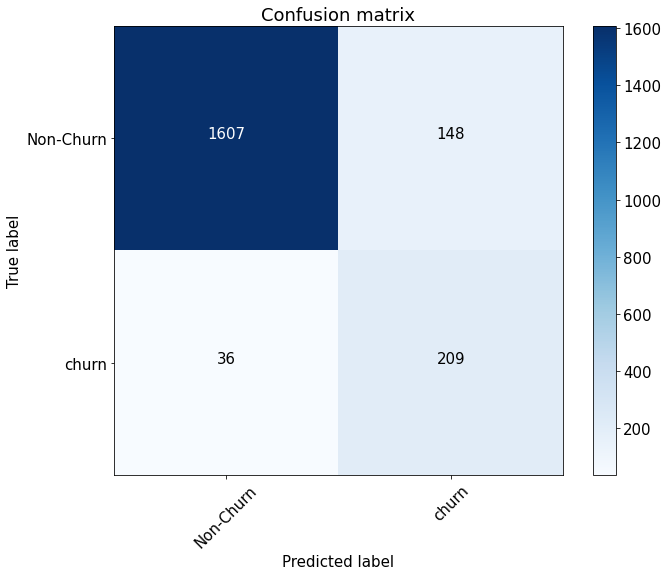

In [47]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test1, preds1>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [48]:
roc_auc_score(y_test1, preds1)

0.957118437118437

Повторить п.2, но используя уже не медиану, а max

In [49]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [50]:
get_user_embedding_max(user_articles_list)

array([0.20423244, 0.35885379, 0.        , 0.02039851, 0.07008426,
       0.04553185, 0.        , 0.13254099, 0.        , 0.15158615,
       0.05349934, 0.07596231, 0.        , 0.07776111, 0.20813957,
       0.        , 0.47686839, 0.52620816, 0.0571858 , 0.        ,
       0.12567103, 0.0179303 , 0.59215724, 0.17717895, 0.03346931])

In [51]:
user_embeddings2 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings2.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings2['uid'] = users['uid'].values
user_embeddings2 = user_embeddings2[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.168447,0.334928,0.0,0.000000,0.156508,0.057764,0.000000,0.063189,0.250932,...,0.021014,0.158958,0.265701,0.258593,0.000000,0.480800,0.096950,0.247130,0.611246,0.159049
1,u108690,0.176569,0.393745,0.0,0.010365,0.091704,0.027368,0.024772,0.105856,0.012418,...,0.019066,0.204523,0.159458,0.099445,0.017720,0.000000,0.070113,0.299351,0.423847,0.049715
2,u108339,0.248242,0.624830,0.0,0.000000,0.024457,0.029453,0.000000,0.075550,0.113508,...,0.024396,0.052859,0.125696,0.131342,0.039788,0.051839,0.066052,0.306442,0.246217,0.053477


In [52]:
X2 = pd.merge(user_embeddings2, target, 'left')
X2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.168447,0.334928,0.0,0.000000,0.156508,0.057764,0.000000,0.063189,0.250932,...,0.158958,0.265701,0.258593,0.000000,0.480800,0.096950,0.247130,0.611246,0.159049,0
1,u108690,0.176569,0.393745,0.0,0.010365,0.091704,0.027368,0.024772,0.105856,0.012418,...,0.204523,0.159458,0.099445,0.017720,0.000000,0.070113,0.299351,0.423847,0.049715,1
2,u108339,0.248242,0.624830,0.0,0.000000,0.024457,0.029453,0.000000,0.075550,0.113508,...,0.052859,0.125696,0.131342,0.039788,0.051839,0.066052,0.306442,0.246217,0.053477,1


In [53]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2[['topic_{}'.format(i) for i in range(25)]], 
                                                    X2['churn'], random_state=0)

In [54]:
logreg2 = LogisticRegression()
#обучим 
logreg2.fit(X_train2, y_train2)

LogisticRegression()

In [55]:
preds2 = logreg2.predict_proba(X_test2)[:, 1]
preds2[:10]

array([0.07701995, 0.00660832, 0.66767094, 0.01799333, 0.01704775,
       0.02657304, 0.14913478, 0.05997545, 0.04648   , 0.09004454])

In [56]:
precision, recall, thresholds = precision_recall_curve(y_test2, preds2)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.340117, F-Score=0.766, Precision=0.728, Recall=0.808


In [57]:
median_metrcs=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]
for i in range(len(metric_list)):
    metric_list[i].append(median_metrcs[i])
metric_list

[[0.2550587871228532, 0.2189519322527232, 0.3401168429768495],
 [0.6441947565543071, 0.6965174129353233, 0.7659574468085106],
 [0.5951557093425606, 0.5865921787709497, 0.7279411764705882],
 [0.7020408163265306, 0.8571428571428571, 0.8081632653061225]]

Confusion matrix, without normalization
[[1681   74]
 [  48  197]]


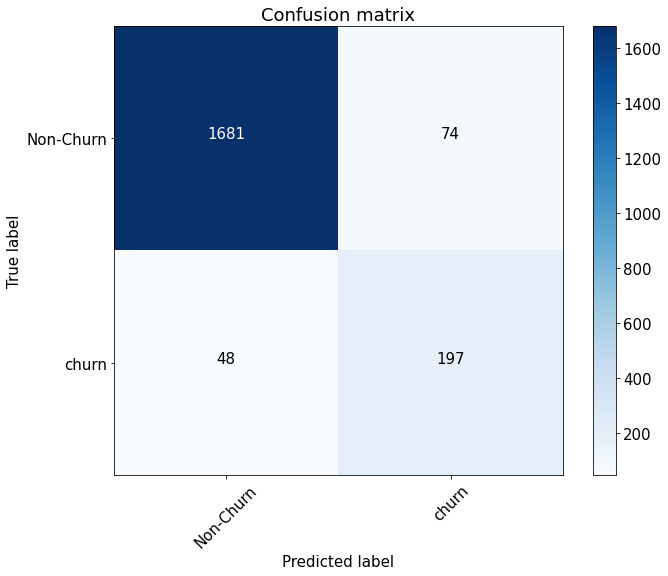

In [58]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test2, preds2>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [59]:
roc_auc_score(y_test2, preds2)

0.9708843537414966